# SmartBeds - One-Class - Pruebas con otros datos
## Grado en Ingeniería Informática
## Universidad de Burgos
##### José Luis Garrido Labrador

In [1]:
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import pickle as pk
from sklearn import metrics as mtr
from transformers import *

### Carga

In [2]:
with open('data/crisis_separadas.pkl','rb') as f:
    crisis_separadas = pk.load(f)

In [3]:
segunda = crisis_separadas[1]
segunda.head()

,DateTime,P1,P2,P3,P4,P5,P6,target
6931232,2019-01-28 21:15:11,0.0,20.491803,18.032787,21.311475,9.016393,6.557377,False
6931233,2019-01-28 21:15:12,0.0,20.491803,18.032787,21.311475,9.016393,6.557377,False
6931234,2019-01-28 21:15:13,0.0,20.491803,18.032787,21.311475,9.016393,6.557377,False
6931235,2019-01-28 21:15:14,0.0,19.672131,18.032787,21.311475,9.836066,6.557377,False
6931236,2019-01-28 21:15:15,0.0,20.491803,18.852459,22.131148,9.836066,6.557377,False


In [4]:
segunda_datos = segunda.iloc[:,1:len(segunda.columns)-1]
segunda_datos.head()

,P1,P2,P3,P4,P5,P6
6931232,0.0,20.491803,18.032787,21.311475,9.016393,6.557377
6931233,0.0,20.491803,18.032787,21.311475,9.016393,6.557377
6931234,0.0,20.491803,18.032787,21.311475,9.016393,6.557377
6931235,0.0,19.672131,18.032787,21.311475,9.836066,6.557377
6931236,0.0,20.491803,18.852459,22.131148,9.836066,6.557377


In [5]:
tercera = crisis_separadas[2]
tercera.head()

,DateTime,P1,P2,P3,P4,P5,P6,target
2164084,2019-02-06 21:11:50,0.0,14.754098,27.049180,30.327869,10.655738,0.0,False
2164085,2019-02-06 21:11:51,0.0,15.573770,26.229508,24.590164,6.557377,0.0,False
2164087,2019-02-06 21:11:52,0.0,19.672131,29.508197,23.770492,4.918033,0.0,False
2164086,2019-02-06 21:11:52,0.0,18.032787,30.327869,27.049180,7.377049,0.0,False
2164088,2019-02-06 21:11:53,0.0,18.032787,25.409836,17.213115,0.000000,0.0,False


In [6]:
tercera_datos = tercera.iloc[:,1:len(tercera.columns)-1]
tercera_datos.head()

,P1,P2,P3,P4,P5,P6
2164084,0.0,14.754098,27.049180,30.327869,10.655738,0.0
2164085,0.0,15.573770,26.229508,24.590164,6.557377,0.0
2164087,0.0,19.672131,29.508197,23.770492,4.918033,0.0
2164086,0.0,18.032787,30.327869,27.049180,7.377049,0.0
2164088,0.0,18.032787,25.409836,17.213115,0.000000,0.0


### Transformers

In [7]:
svg = SavgolTransformer(15)
btr = ButterTransformer(3,0.05)
nor = Normalizer(max_=100)
avg = PipelineTransformer(StatisticsTransformer(mode='mean',window=25),nor)
std = PipelineTransformer(StatisticsTransformer(mode='std',window=25),nor)
ran = PipelineTransformer(StatisticsTransformer(mode='range',window=25),nor)
var = VarianceThresholdPD(threshold=0.5)
con = ConcatenateTransformer(avg,std,ran)
#Se quita el ajuste de varianza para mantener el mismo número de entradas
pps = PipelineTransformer(svg,con)
ppb = PipelineTransformer(btr,con)
ppr = PipelineTransformer(con)
ppr_s = PipelineTransformer(svg)
ppr_b = PipelineTransformer(btr)

#Reparador de targets
trT = MoveTargetsTransformer(window=25)

## Entrenamiento con primera crisis
### Brutos

In [8]:
with open('classifiers/RAW-seizure-classifier.pkl','rb') as f:
    raw_clf = pk.load(f)

In [9]:
predict = raw_clf.predict(segunda_datos)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [10]:
mtr.confusion_matrix(segunda['target'],predict)

array([[102176,      0],
       [  2252,      0]])

0.3811828067086138


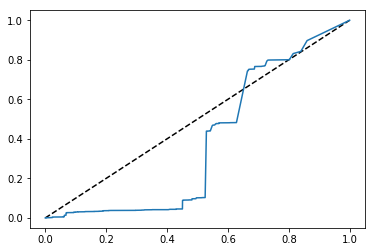

In [11]:
scr = raw_clf.score_samples(segunda_datos)
fpr, tpr, thr = mtr.roc_curve(segunda['target'],scr)
print(mtr.roc_auc_score(segunda['target'],scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [12]:
predict = raw_clf.predict(tercera_datos)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [13]:
mtr.confusion_matrix(tercera['target'],predict)

array([[86990,     0],
       [ 2741,     0]])

0.30427739789352926


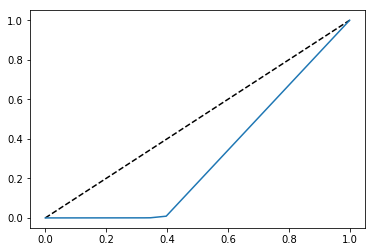

In [14]:
scr = raw_clf.score_samples(tercera_datos)
print(mtr.roc_auc_score(tercera['target'],scr))
fpr, tpr, thr = mtr.roc_curve(tercera['target'],scr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### Estadísticos

In [15]:
with open('classifiers/STATS-seizure-classifier.pkl','rb') as f:
    sts_clf = pk.load(f)

In [16]:
prd = con.fit_transform(segunda_datos).dropna()
predict = sts_clf.predict(prd)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [17]:
target = trT.fit_transform((pd.concat((prd,segunda['target']),axis=1)).dropna())

target = target['target']
target.head()

6931256    False
6931257    False
6931258    False
6931259    False
6931260    False
Name: target, dtype: bool

In [18]:
mtr.confusion_matrix(target,predict)

array([[102177,      0],
       [  2227,      0]])

0.5


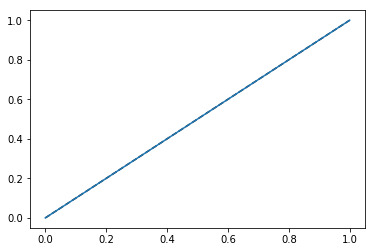

In [19]:
scr = sts_clf.score_samples(prd)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [20]:
prd = con.fit_transform(tercera_datos).dropna()
predict = sts_clf.predict(prd)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [21]:
target = trT.fit_transform((pd.concat((prd,tercera['target']),axis=1)).dropna())

target = target['target']
target.head()

2164108    False
2164109    False
2164110    False
2164111    False
2164112    False
Name: target, dtype: bool

In [22]:
mtr.confusion_matrix(target,predict)

array([[86975,     0],
       [ 2732,     0]])

0.5


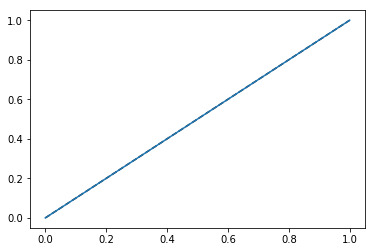

In [23]:
scr = sts_clf.score_samples(prd)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### SavGol

In [24]:
with open('classifiers/SAVGOL-seizure-classifier.pkl','rb') as f:
    sav_clf = pk.load(f)

In [25]:
sav = ppr_s.fit_transform(segunda_datos).dropna()
predict = sav_clf.predict(sav)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [26]:
target = (pd.concat((sav,segunda['target']),axis=1)).dropna()['target']
target.head()

6931232    False
6931233    False
6931234    False
6931235    False
6931236    False
Name: target, dtype: bool

In [27]:
mtr.confusion_matrix(target,predict)

array([[102176,      0],
       [  2252,      0]])

0.386763156711729


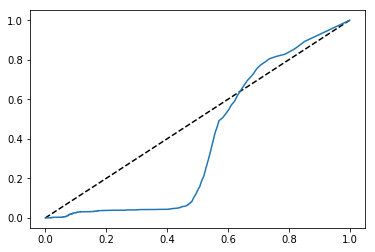

In [28]:
scr = sav_clf.score_samples(sav)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [29]:
sav = ppr_s.fit_transform(tercera_datos).dropna()
predict = sav_clf.predict(sav)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [30]:
target = (pd.concat((sav,tercera['target']),axis=1)).dropna()['target']
target.head()

2164084    False
2164085    False
2164087    False
2164086    False
2164088    False
Name: target, dtype: bool

In [31]:
mtr.confusion_matrix(target,predict)

array([[86990,     0],
       [ 2741,     0]])

0.33407862972755487


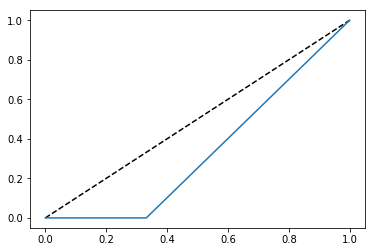

In [32]:
scr = sav_clf.score_samples(sav)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### Butter

In [33]:
with open('classifiers/BUTTER-seizure-classifier.pkl','rb') as f:
    btt_clf = pk.load(f)

In [34]:
but = ppr_b.fit_transform(segunda_datos).dropna()
predict = btt_clf.predict(but)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [35]:
target = (pd.concat((but,segunda['target']),axis=1)).dropna()['target']
target.head()

6931232    False
6931233    False
6931234    False
6931235    False
6931236    False
Name: target, dtype: bool

In [36]:
mtr.confusion_matrix(target,predict)

array([[102176,      0],
       [  2252,      0]])

0.3831964368311788


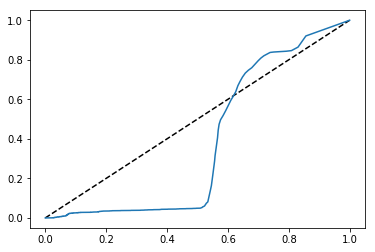

In [37]:
scr = btt_clf.score_samples(but)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [38]:
but = ppr_b.fit_transform(tercera_datos).dropna()
predict = btt_clf.predict(but)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [39]:
target = (pd.concat((but,tercera['target']),axis=1)).dropna()['target']
target.head()

2164084    False
2164085    False
2164087    False
2164086    False
2164088    False
Name: target, dtype: bool

In [40]:
mtr.confusion_matrix(target,predict)

array([[86990,     0],
       [ 2741,     0]])

0.3324462581905966


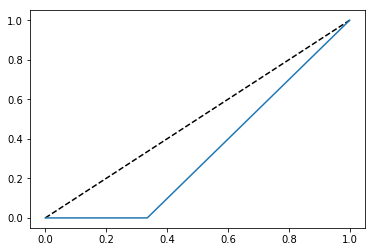

In [41]:
scr = btt_clf.score_samples(but)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### SavGol Estadísticos

In [42]:
with open('classifiers/SAVGOL-STATS-seizure-classifier.pkl','rb') as f:
    sts_clf = pk.load(f)

In [43]:
sst = pps.fit_transform(segunda_datos).dropna()
predict = sts_clf.predict(sst)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [44]:
target = trT.fit_transform((pd.concat((sst,segunda['target']),axis=1)).dropna())

target = target['target']
target.head()

6931256    False
6931257    False
6931258    False
6931259    False
6931260    False
Name: target, dtype: bool

In [45]:
mtr.confusion_matrix(target,predict)

array([[102177,      0],
       [  2227,      0]])

0.5


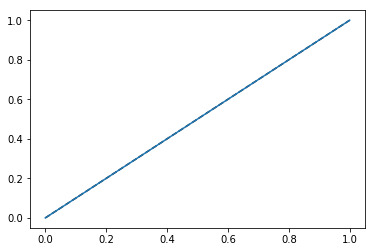

In [46]:
scr = sts_clf.score_samples(sst)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [47]:
sst = pps.fit_transform(tercera_datos).dropna()
predict = sts_clf.predict(sst)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [48]:
target = trT.fit_transform((pd.concat((sst,tercera['target']),axis=1)).dropna())

target = target['target']
target.head()

2164108    False
2164109    False
2164110    False
2164111    False
2164112    False
Name: target, dtype: bool

In [49]:
mtr.confusion_matrix(target,predict)

array([[86975,     0],
       [ 2732,     0]])

0.5


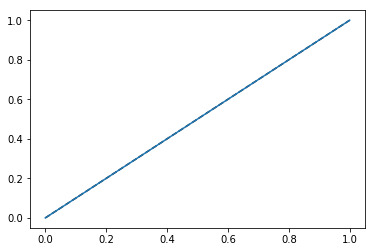

In [50]:
scr = sts_clf.score_samples(sst)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### Butter Estadísticos

In [51]:
with open('classifiers/BUTTER_STATS-seizure-classifier.pkl','rb') as f:
    bts_clf = pk.load(f)

In [52]:
bts = ppb.fit_transform(segunda_datos).dropna()
predict = bts_clf.predict(bts)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [53]:
target = trT.fit_transform((pd.concat((bts,segunda['target']),axis=1)).dropna())

target = target['target']
target.head()

6931256    False
6931257    False
6931258    False
6931259    False
6931260    False
Name: target, dtype: bool

In [54]:
mtr.confusion_matrix(target,predict)

array([[102177,      0],
       [  2227,      0]])

0.5


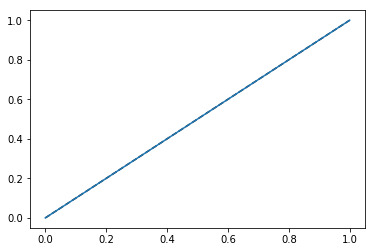

In [55]:
scr = bts_clf.score_samples(bts)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [56]:
bts = ppb.fit_transform(tercera_datos).dropna()
predict = bts_clf.predict(bts)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [57]:
target = trT.fit_transform((pd.concat((bts,tercera['target']),axis=1)).dropna())

target = target['target']
target.head()

2164108    False
2164109    False
2164110    False
2164111    False
2164112    False
Name: target, dtype: bool

In [58]:
mtr.confusion_matrix(target,predict)

array([[86975,     0],
       [ 2732,     0]])

0.5


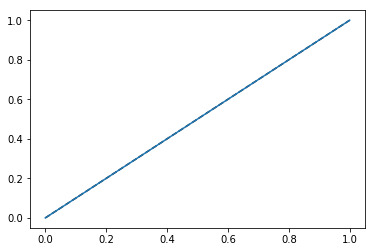

In [59]:
scr = bts_clf.score_samples(bts)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)